In [108]:
import os
import torch
import cv2
from torchvision.datasets import CocoDetection
from simple_copy_paste.simple_copy_paste import copy_paste_class
from torchvision import tv_tensors
import numpy as np
from torchvision.io import read_image

from torchvision.transforms.v2 import functional as F

min_keypoints_per_image = 10


def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)


def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)


def has_valid_annotation(anno):
    # if it's empty, there is no annotation
    if len(anno) == 0:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different critera for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True

    return False


@copy_paste_class
class CocoDetectionCP(CocoDetection):
    def __init__(self, root, annFile, transforms):
        super(CocoDetectionCP, self).__init__(root, annFile, None, None, transforms)

        # filter images without detection annotations
        ids = []
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anno = self.coco.loadAnns(ann_ids)
            if has_valid_annotation(anno):
                ids.append(img_id)
        self.ids = ids

    def collate_fn(_, batch):
        return tuple(zip(*batch))

    def load_example(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        target = self.coco.loadAnns(ann_ids)

        path = self.coco.loadImgs(img_id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # convert all of the target segmentations to masks
        # bboxes are expected to be (y1, x1, y2, x2, category_id)
        masks = []
        bboxes = []
        for ix, obj in enumerate(target):
            masks.append(self.coco.annToMask(obj))
            bboxes.append(obj["bbox"] + [obj["category_id"]] + [ix])

        # pack outputs into a dict
        output = {"image": image, "masks": masks, "bboxes": bboxes}

        return self.transforms(**output)


class CustomCocoDetection(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file, transforms)
        self.img_folder = img_folder

    @staticmethod
    def collate_fn(batch):
        images = list(image for image, _ in batch)
        targets = list(target for _, target in batch)
        return images, targets

    def __getitem__(self, index):
        image_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        target = self.coco.loadAnns(ann_ids)

        # Process target to match your desired format
        output_target = {}
        output_target["boxes"] = []
        output_target["labels"] = []
        output_target["masks"] = []

        for obj in target:
            # Convert boxes to x1, y1, x2, y2
            x, y, w, h = obj["bbox"]
            x2 = x + w
            y2 = y + h
            output_target["boxes"].append(torch.tensor([x, y, x2, y2]).float())

            output_target["labels"].append(obj["category_id"])

            # Assuming masks are RLE encoded
            mask = self.coco.annToMask(obj)
            output_target["masks"].append(mask)

        path = self.coco.loadImgs(image_id)[0]["file_name"]
        image = read_image(os.path.join(self.img_folder, path))
        image = tv_tensors.Image(image)
        # Convert to tensors
        output_target["boxes"] = torch.tensor(
            np.array(output_target["boxes"])
        ).float()  # Ensure float for bounding boxes
        output_target["labels"] = torch.tensor(output_target["labels"]).long()
        output_target["masks"] = torch.tensor(np.array(output_target["masks"]))
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            output_target["boxes"], format="XYXY", canvas_size=F.get_size(image)
        )
        target["masks"] = tv_tensors.Mask(output_target["masks"])
        target["labels"] = output_target["labels"]

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

In [117]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [118]:
import albumentations as A

data = CustomCocoDetection(
    img_folder="data/val2017",
    ann_file="coco_subset_annotations_val.json",
    transforms=get_transform(train=True),
)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [119]:
data[4]

(tensor([[[0.9569, 0.9569, 0.9529,  ..., 0.2863, 0.2157, 0.2667],
          [0.9451, 0.9373, 0.9294,  ..., 0.3098, 0.2157, 0.2706],
          [0.9255, 0.9098, 0.8902,  ..., 0.3373, 0.2941, 0.2941],
          ...,
          [0.6157, 0.5765, 0.3608,  ..., 0.1569, 0.1490, 0.1373],
          [0.6471, 0.7804, 0.7529,  ..., 0.1098, 0.1137, 0.1255],
          [0.6588, 0.6706, 0.6275,  ..., 0.0667, 0.0706, 0.0784]],
 
         [[0.9725, 0.9725, 0.9725,  ..., 0.2196, 0.2000, 0.2157],
          [0.9608, 0.9569, 0.9608,  ..., 0.2471, 0.2000, 0.2235],
          [0.9412, 0.9294, 0.9255,  ..., 0.2549, 0.2314, 0.2078],
          ...,
          [0.6627, 0.6235, 0.3922,  ..., 0.1216, 0.1216, 0.1098],
          [0.6941, 0.8431, 0.8706,  ..., 0.0863, 0.0902, 0.0980],
          [0.7137, 0.7176, 0.6902,  ..., 0.0471, 0.0431, 0.0510]],
 
         [[0.9843, 0.9843, 0.9882,  ..., 0.1922, 0.1647, 0.1529],
          [0.9725, 0.9686, 0.9725,  ..., 0.1961, 0.1569, 0.1765],
          [0.9451, 0.9412, 0.9451,  ...,

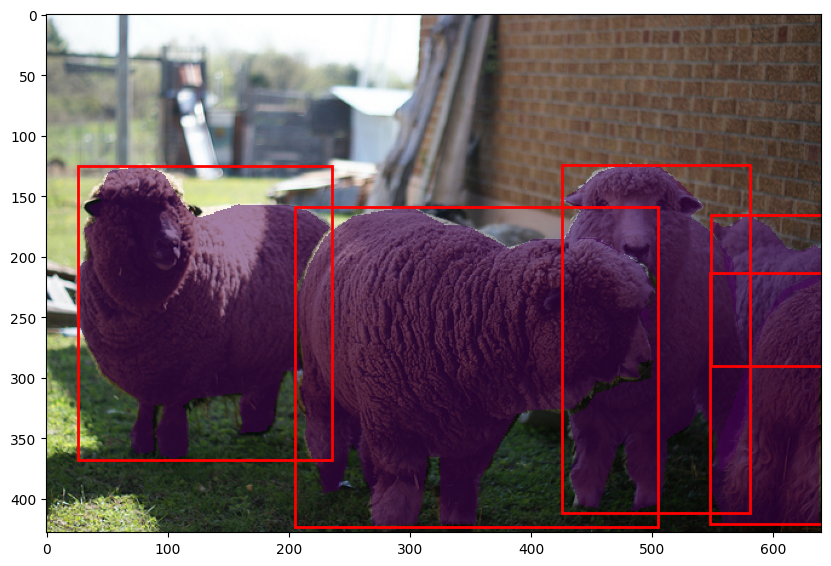

In [120]:
from matplotlib import pyplot as plt


# plot with bboxes and masks
def plot_image(image, target):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image.permute(1, 2, 0))

    for box, mask in zip(target["boxes"], target["masks"]):
        x, y, x2, y2 = box
        rect = plt.Rectangle(
            (x, y), x2 - x, y2 - y, fill=False, edgecolor="red", linewidth=2
        )
        ax.add_patch(rect)

        mask = mask.numpy()
        mask = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask, alpha=0.5, cmap="viridis")

    plt.show()


plot_image(*data[4])